正方格子 ハイゼンベルグ模型
1. 上 J' 下 SA 横軸 t (初期状態手で入れる) 100点 stacked_J'_SA_init_hand
2. 上 J' 下 SA 横軸 t (基底状態) 100点 stacked_J'_SA_init_ground
3. 上 J' 下 SA 横軸 t (基底状態 Tcut = 0.0, 2.5, 5.0) 100点 stacked_J'_SA_Tcut0.0-2.5-5.0
4. SA Tcut 10%以下で斜線 J = 1 20点 SA_Tcut0.0to10.0_shadow
5. SA Tcut (J = 0.5, 1.0, 2.0) 20点 SA_Tcut_J0.5-1.0-2.0
6. 5をJTcutで整理 SA_JTcut_J0.5-1.0-2.0

In [15]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import lru_cache
import requests
# 通知設定
DISCORD_WEBHOOK_URL = "https://discord.com/api/webhooks/1442746910623666216/5jfE2fqcUXUx1WMGc2Ek46bUQ5KTYD4Envhma3RgUa3-kD7-PQe1oqCahSX4twZDiATW"
def notify_discord(message: str):
    payload = {"content": message}
    try:
        r = requests.post(DISCORD_WEBHOOK_URL, json=payload, timeout=5)
        r.raise_for_status()
        print("✅ Discord 通知送信 OK")
    except Exception as e:
        print("⚠ Discord 通知に失敗:", e)

# グラフ設定
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 軸ラベル
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

markers = ['o', 's', '^', 'v', 'D', '*', '+', 'x']
colors = [
    "black",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:red",
    "tab:brown",
    "tab:gray",
]
OUTDIR = Path("charts")
def save_fig(fig, stem: str):
    fig.savefig(OUTDIR / f"{stem}.pdf", bbox_inches="tight", dpi=300) 
    print(f"saved: {OUTDIR / (stem + '.pdf')}")

# データ保存
DATADIR = Path("data")

# データ読み込み例
# fname = DATADIR / "square_sa_tcut.npz" 

# dat = np.load(fname)

# N_list  = dat["N"]   # shape (nN,)
# hx_list = dat["hx_list"]  # shape (nHx,)
# Tcut_list = dat["Tcut"]
# EE      = dat["EE"]       # shape (nN, nHx)

In [16]:
tlist = np.linspace(0.0, 10.0, 1001)
# ============ 2D 格子のインデックス変換 ============

def _lx_ly(N: int) -> tuple[int, int]:
    L = int(np.sqrt(N))
    assert L * L == N, "N は正方格子 (L^2) を仮定してる"
    return L, L

def _idx(x, y, Lx):
    return y * Lx + x


# ============ 結合と left_sites をまとめてキャッシュ ============

@lru_cache(maxsize=None)
def get_bonds(N: int, delta: float = 1.0):
    """
    N, delta だけで決まる演算子・結合・left_sites を全部まとめて返す
    """
    Lx, Ly = _lx_ly(N)
    sx, sy, sz = [0.5 * M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sy = [op_at(i, sy) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    # 近接結合を列挙
    bonds_all: list[tuple[int, int]] = []
    for y in range(Ly):
        for x in range(Lx):
            i = _idx(x, y, Lx)
            if x + 1 < Lx:
                j = _idx(x + 1, y, Lx)
                bonds_all.append((i, j))
            if y + 1 < Ly:
                j = _idx(x, y + 1, Lx)
                bonds_all.append((i, j))

    # カットする結合: x = 1 と 2 の間 (縦方向に Ly 本)
    cut_list = []
    for y in range(Ly):
        i = _idx(1, y, Lx)
        j = _idx(2, y, Lx)
        cut_list.append((i, j))

    cut_set = set(cut_list)
    keep_bonds = [b for b in bonds_all if b not in cut_set]

    def H_bond_unit(i, j):
        Sxi, Syi, Szi = Sx[i], Sy[i], Sz[i]
        Sxj, Syj, Szj = Sx[j], Sy[j], Sz[j]
        return Sxi * Sxj + Syi * Syj + delta * Szi * Szj

    H_keep_unit = sum(H_bond_unit(i, j) for (i, j) in keep_bonds)
    Hcut_unit   = sum(H_bond_unit(i, j) for (i, j) in cut_list)
    H_all_unit  = H_keep_unit + Hcut_unit

    # left half: x = 0,1 列
    cut_pos = 2  # x = 0,1 が left, x = 2,3 が right (Lx=4 前提)
    left_sites = [_idx(x, y, Lx) for y in range(Ly) for x in range(cut_pos)]

    return H_keep_unit, Hcut_unit, H_all_unit, left_sites


@lru_cache(maxsize=None)
def get_psi0(N: int, J: float, delta: float = 1.0):
    """(N, J, delta) で決まる初期基底状態"""
    H_keep_unit, Hcut_unit, H_all_unit, _ = get_bonds(N, delta)
    H_all = J * H_all_unit
    _, psi0 = H_all.groundstate(sparse=True)
    return psi0


# ========= メイン: Tcut ごとの時間発展 =========

def ramp(t, T_cut: float):
    if T_cut == 0.0:
        return 1.0 if t <= 0.0 else 0.0
    if t <= 0.0:
        return 1.0
    if t >= T_cut:
        return 0.0
    return 1.0 - t / T_cut


def simulate(N: int, J: float, Tcut: float, tlist: np.ndarray, delta: float = 1.0):
    H_keep_unit, Hcut_unit, H_all_unit, left_sites = get_bonds(N, delta)
    H_static = -J * H_keep_unit

    # ramp に Tcut を埋め込んでラムダを1引数にしておくと少しだけ軽い
    def ramp_one_arg(t, args):
        return ramp(t, Tcut)

    opts = qt.Options(
        method="adams",      # 非剛性ならこっちの方が速いことが多い
        rtol=1e-5,
        atol=1e-7,
        nsteps=50_000,
        max_step=(tlist[-1] - tlist[0]) / max(len(tlist) - 1, 1) * 5.0,
        store_states=True,
        progress_bar=None,
    )

    Ht = [H_static, [-J * Hcut_unit, ramp_one_arg]]
    psi0 = get_psi0(N, J, delta)
    res = qt.sesolve(Ht, psi0, tlist, options=opts)

    # 各時刻で SA(t) を計算
    SA_t = np.array([
        float(qt.entropy_vn(qt.ptrace(psi_t, left_sites), base=2))
        for psi_t in res.states
    ])
    SA_Tcut = SA_t[-1]

    # 必要なら J'(t) を返す
    Jprime = J * np.array([ramp(t, Tcut) for t in tlist])

    return Jprime, SA_t, SA_Tcut


/Users/naoki/Desktop/RESEARCH/実験/qutip/venv/lib/python3.14/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/var/folders/v5/c_qlc9ds44ldxhm179s7h1mh0000gn/T/ipykernel_37694/3380652935.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


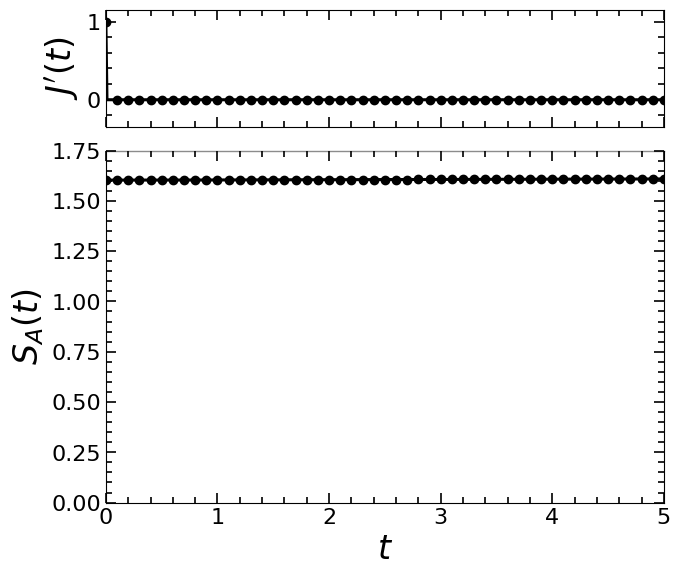

✅ Discord 通知送信 OK
saved: charts/stacked_J'_SA_init_hand.pdf


In [17]:
# 1 上 J' 下 SA 横軸 t (初期状態手で入れる) 100点 TODO: 手で設定
fig1 = plt.figure(figsize=(7.2, 6.4))
gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0.1)
ax_top = fig1.add_subplot(gs[0, 0])
ax_bot = fig1.add_subplot(gs[1, 0], sharex=ax_top)
inward_ticks(ax_top); inward_ticks(ax_bot)

N = 16
J = 1.0
Tcut = 0.0
Jprime, SA_t, _ = simulate(N=N, J=J, Tcut=Tcut, tlist=tlist)

# # --- Top
ln, = ax_top.plot(
    tlist, 
    Jprime,
    marker=markers[0],
    color=colors[0],
    markersize=6.0,
    markevery=10
)

ax_top.set_xlim(0.0, 5.0)
ax_top.set_ylim(-0.35, 1.15)
ax_top.set_ylabel(r"$J'(t)$",fontsize=24)
ax_top.tick_params(labelbottom=False)
ax_top.set_title("")

# --- Bottom
ln, = ax_bot.plot(
    tlist, 
    SA_t,
    marker=markers[0],
    color=colors[0],
    markersize=6.0,
    markevery=10,
)

ax_bot.set_prop_cycle(color=plt.cm.tab10.colors)
ax_bot.set_xlim(0.0, 5.0)
ax_bot.set_xlabel(r"$t$", fontsize=24)
ax_bot.set_ylim(0.0, 1.75)
ax_bot.set_ylabel(r"$S_A(t)$", fontsize=24)
ax_bot.spines['top'].set_alpha(0.45)
ax_bot.spines['top'].set_linewidth(1.0)

fig1.tight_layout()
plt.show()

# データ保存
npz_path = DATADIR / f"stacked_J'_SA_init_hand.npz"
np.savez(
    npz_path,
    N=N,
    Jprime=Jprime,
    tlist=tlist,
    SA_t=SA_t
)

notify_discord(message=f"square sim 1 done")
# グラフ保存
save_fig(fig=fig1, stem="stacked_J'_SA_init_hand")

/Users/naoki/Desktop/RESEARCH/実験/qutip/venv/lib/python3.14/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/var/folders/v5/c_qlc9ds44ldxhm179s7h1mh0000gn/T/ipykernel_37694/517611211.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig2.tight_layout()


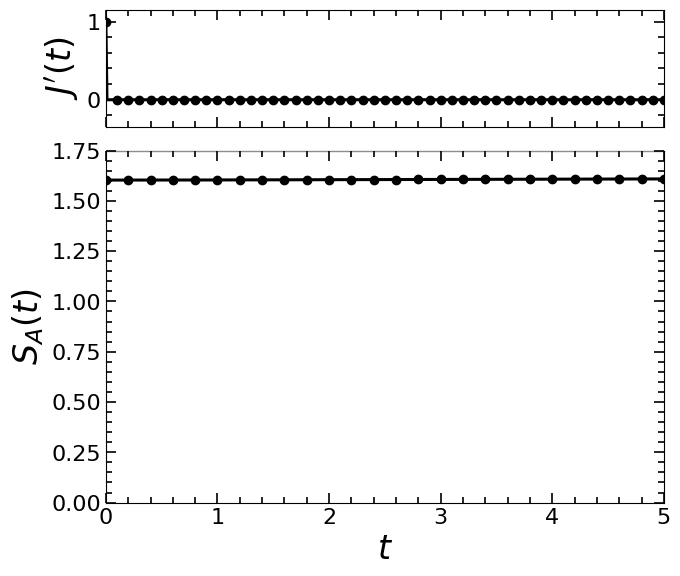

✅ Discord 通知送信 OK
saved: charts/stacked_J'_SA_init_ground.pdf


In [23]:
# 2 上 J' 下 SA 横軸 t (基底状態) 100点
fig2 = plt.figure(figsize=(7.2, 6.4))
gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0.1)
ax_top = fig2.add_subplot(gs[0, 0])
ax_bot = fig2.add_subplot(gs[1, 0], sharex=ax_top)
inward_ticks(ax_top); inward_ticks(ax_bot)

N = 16
J = 1.0
Tcut = 0.0
Jprime, SA_t, _ = simulate(N=N, J=J, Tcut=Tcut, tlist=tlist)

# # --- Top
ln, = ax_top.plot(
    tlist, 
    Jprime,
    marker=markers[0],
    color=colors[0],
    markersize=6.0,
    markevery=10
)

ax_top.set_xlim(0.0, 5.0)
ax_top.set_ylim(-0.35, 1.15)
ax_top.set_ylabel(r"$J'(t)$",fontsize=24)
ax_top.tick_params(labelbottom=False)
ax_top.set_title("")

# --- Bottom
ln, = ax_bot.plot(
    tlist, 
    SA_t,
    marker=markers[0],
    color=colors[0],
    markersize=6.0,
    markevery=20
)

ax_bot.set_prop_cycle(color=plt.cm.tab10.colors)
ax_bot.set_xlim(0.0, 5.0)
ax_bot.set_xlabel(r"$t$", fontsize=24)
ax_bot.set_ylim(0.0, 1.75)
ax_bot.set_ylabel(r"$S_A(t)$", fontsize=24)
ax_bot.spines['top'].set_alpha(0.45)
ax_bot.spines['top'].set_linewidth(1.0)

fig2.tight_layout()
plt.show()

# データ保存
npz_path = DATADIR / f"stacked_J'_SA_init_ground.npz"
np.savez(
    npz_path,
    Jprime=Jprime,
    tlist=tlist,
    SA_t=SA_t
)

notify_discord(message=f"square sim 2 done")
# グラフ保存
save_fig(fig=fig2, stem="stacked_J'_SA_init_ground")

/Users/naoki/Desktop/RESEARCH/実験/qutip/venv/lib/python3.14/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/var/folders/v5/c_qlc9ds44ldxhm179s7h1mh0000gn/T/ipykernel_37694/3216231295.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig3.tight_layout()


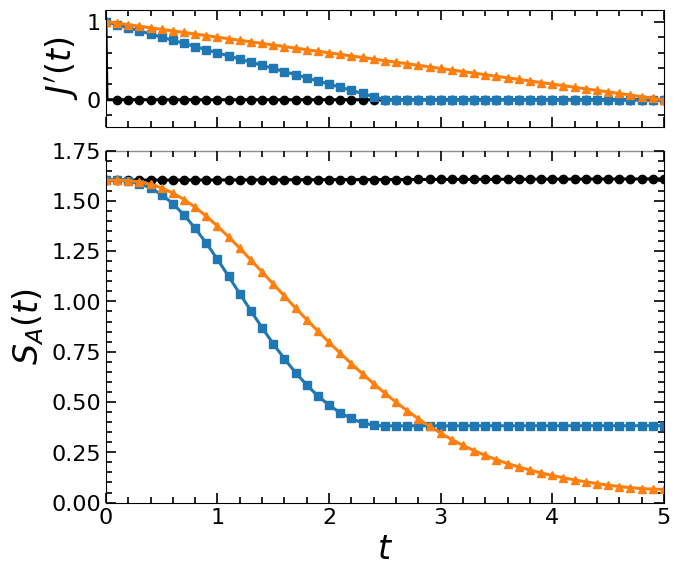

✅ Discord 通知送信 OK
saved: charts/stacked_J'_SA_Tcut0.0-2.5-5.0.pdf


In [27]:
# 3 上 J' 下 SA 横軸 t Tcut 0.0, 2.5, 5.0 (基底状態) 50点
# # データ読み込み
# fname = DATADIR / "stacked_J'_SA_Tcut0.0-2.5-5.0.npz" 

# dat = np.load(fname)

# Jprimelist = dat["Jprime"]
# Tcut_list = dat["Tcut_list"]
# SA_Tcut_all = dat["SA_Tcut_all"]

fig3 = plt.figure(figsize=(7.2, 6.4))
gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0.1)
ax_top = fig3.add_subplot(gs[0, 0])
ax_bot = fig3.add_subplot(gs[1, 0], sharex=ax_top)
inward_ticks(ax_top); inward_ticks(ax_bot)

N = 16
J = 1.0
Tcut_list = [0.0, 2.5, 5.0]

Jprime_all = []
SA_t_all = []

for i, Tcut in enumerate(Tcut_list):
    Jprime, SA_t, _ = simulate(N=N, J=J, Tcut=Tcut, tlist=tlist)
    Jprime_all.append(Jprime)
    SA_t_all.append(SA_t)

    # # --- Top
    ln, = ax_top.plot(
        tlist, 
        Jprime,
        marker=markers[i],
        color=colors[i],
        markersize=6.0,
        markevery=10,
    )
    
    ax_top.set_xlim(0.0, 5.0)
    ax_top.set_ylim(-0.35, 1.15)
    ax_top.set_ylabel(r"$J'(t)$",fontsize=24)
    ax_top.tick_params(labelbottom=False)
    ax_top.set_title("")
    
    # --- Bottom
    ln, = ax_bot.plot(
        tlist, 
        SA_t,
        marker=markers[i],
        color=colors[i],
        markersize=6.0,
        markevery=10,
    )

ax_bot.set_prop_cycle(color=plt.cm.tab10.colors)
ax_bot.set_xlim(0.0, 5.0)
ax_bot.set_xlabel(r"$t$", fontsize=24)
ax_bot.set_ylim(0.0, 1.75)
ax_bot.set_ylabel(r"$S_A(t)$", fontsize=24)
ax_bot.spines['top'].set_alpha(0.45)
ax_bot.spines['top'].set_linewidth(1.0)

fig3.tight_layout()
plt.show()

# データ保存
npz_path = DATADIR / f"stacked_J'_SA_Tcut0.0-2.5-5.0.npz"
np.savez(
    npz_path,
    Jprime=Jprime,
    tlist=tlist,
    Tcut_list=Tcut_list,
    SA_t=SA_t
)

notify_discord(message=f"square sim 3 done")
# グラフ保存
save_fig(fig=fig3, stem="stacked_J'_SA_Tcut0.0-2.5-5.0")

In [20]:
# # 4 SA Tcut 10%以下で斜線 50点
# fig4, ax4 = plt.subplots(figsize=(6.9, 4.6))
# inward_ticks(ax4)

# N = 16
# J = 1.0
# Tcut_list = np.linspace(0.0, 10.0, 21)
# tlist = np.linspace(0.0, 10.0, 51)

# SA_Tcut_all = []

# for i, Tcut in enumerate(Tcut_list):
#     _, _, SA_Tcut = simulate(N=N, J=J, Tcut=Tcut, tlist=tlist)
#     print(f"Tcut is {Tcut}")
#     SA_Tcut_all.append(SA_Tcut)
    
# ln, = ax4.plot(
#     Tcut_list, 
#     SA_Tcut_all,
#     marker=markers[0],
#     color=colors[0],
#     markersize=6.0
# )

# Tcut_array = np.array(Tcut_list)
# mask = (Tcut_array <= 4)  # 0〜4 の範囲だけ
# ax4.fill_between(
#     Tcut_list, SA_Tcut_all, 0,                       # 曲線とx軸(=0)の間
#     where=mask,                    # 0〜4 のみ
#     interpolate=True,              # 4 できっちり境界にする
#     facecolor='none',              # 斜線だけにしたい場合
#     hatch='///',                   # 斜線（'\\\\', 'xx' なども可）
#     edgecolor='0.4', linewidth=0,  # 斜線の色・線幅
#     zorder=0                       # 曲線より背面に
# )

# ax4.set_prop_cycle(color=plt.cm.tab10.colors)
# ax4.set_xlim(0.0, 10.0)
# ax4.set_xlabel(r"$T_{\mathrm{cut}}$", fontsize=24)
# ax4.set_ylim(0.0, 1.75)
# ax4.set_ylabel(r"$S_A(t=T_cut)$", fontsize=24)

# fig4.tight_layout()
# plt.show()

# # データ保存
# npz_path = DATADIR / f"SA_Tcut0.0to10.0_shadow.npz"
# np.savez(
#     npz_path,
#     Tcut_list=Tcut_list,
#     SA_Tcut_all=SA_Tcut_all
# )

# notify_discord(message=f"square sim 4 done")
# # グラフ保存
# save_fig(fig=fig4, stem="SA_Tcut0.0to10.0_shadow")

In [21]:
# # 5 SA Tcut (J = 0.5, 1.0, 2.0) 20点
# # # データ読み込み
# # fname = DATADIR / "SA_Tcut_J0.5-1.0-2.0.npz" 

# # dat = np.load(fname)

# # J_list = dat["J_list"]
# # Tcut_list = dat["Tcut_list"]
# # SA_Tcut_all = dat["SA_Tcut_all"]

# fig5, ax5 = plt.subplots(figsize=(6.9, 4.6))
# inward_ticks(ax5)

# N = 16
# J_list = [2.0, 1.0, 0.5]
# Tcut_list = np.linspace(0.0, 20.0, 41)
# tlist = np.linspace(0.0, 20.0, 101)

# # max_pts, min_pts = 20, 10        # マーカー点数（上限20想定）
# mksizes=[22.0, 12.0, 9.0]
# lnwidths=[16.0, 8.0, 1.0]

# SA_Tcut_all = []
# for i, J in enumerate(J_list):
#     # データ取得はこっち
#     SA_Tcut_J = []
#     for j, Tcut in enumerate(Tcut_list):
#         _, _, SA_Tcut = simulate(N=N, J=J, Tcut=Tcut, tlist=tlist)
#         print(f"J is {J}, Tcut is {Tcut}")
#         SA_Tcut_J.append(SA_Tcut)
#     # # グラフ作成はこっち
#     # SA_Tcut_J = SA_Tcut_all[i]
#     ln, = ax5.plot(
#         Tcut_list, 
#         SA_Tcut_J,
#         marker=markers[i],
#         color=colors[i],
#         markersize=mksizes[i],
#         linewidth=lnwidths[i],
#         zorder=i
#     )
#     SA_Tcut_all.append(SA_Tcut_J)

# ax5.set_prop_cycle(color=plt.cm.tab10.colors)
# ax5.set_xlim(0.0, 10.0)
# ax5.set_xlabel(r"$T_{\mathrm{cut}}$", fontsize=24)
# ax5.set_ylim(0.0, 1.75)
# ax5.set_ylabel(r"$S_A(t=T_\mathrm{cut})$", fontsize=24)

# fig5.tight_layout()
# plt.show()

# # データ保存
# npz_path = DATADIR / f"SA_Tcut_J0.5-1.0-2.0.npz"
# np.savez(
#     npz_path,
#     J_list=J_list,
#     Tcut_list=Tcut_list,
#     SA_Tcut_all=SA_Tcut_all
# )

# notify_discord(message=f"square sim 5 done")
# # グラフ保存
# save_fig(fig=fig5, stem="SA_Tcut_J0.5-1.0-2.0")

In [22]:
# # 6 SA JTcut (J = 0.5, 1.0, 2.0) 20点
# # データ読み込み
# fname = DATADIR / "SA_Tcut_J0.5-1.0-2.0.npz" 

# dat = np.load(fname)

# J_list = dat["J_list"]
# print(J_list)
# Tcut_list = dat["Tcut_list"]
# SA_Tcut_all = dat["SA_Tcut_all"]

# fig5, ax5 = plt.subplots(figsize=(6.9, 4.6))
# inward_ticks(ax5)

# for i, J in enumerate(J_list):
#     ln, = ax5.plot(
#         J*Tcut_list, 
#         SA_Tcut_all[i],
#         marker=markers[i],
#         color=colors[i],
#         markersize=mksizes[i],
#         linewidth=lnwidths[i],
#         zorder=i
#     )

# ax5.set_prop_cycle(color=plt.cm.tab10.colors)
# ax5.set_xlim(0.0, 10.0)
# ax5.set_xlabel(r"$JT_{\mathrm{cut}}$", fontsize=24)
# ax5.set_ylim(0.0, 1.75)
# ax5.set_ylabel(r"$S_A(t=T_cut)$", fontsize=24)

# fig5.tight_layout()
# plt.show()

# notify_discord(message=f"square sim 6 done")
# # グラフ保存
# save_fig(fig=fig5, stem="SA_JTcut_J0.5-1.0-2.0s")